<a id='top'></a>
<h1 align="center">MCMC Tutorial Chapter 2</h1>

**Authors:** John Letey, Mingxuan Zhang, and Tony E Wong

In Chapter 1, we have learned how to use MCMC to solve the prameter estimation problem, but MCMC has way more capabilities than just that. In this chapter we will learn how to use MCMC to fit a distribution. We will use synthetic data generated from two different distributions (the Normal distribution and the GEV distribution), and we will know the parameters and want to recover the parameters from the dataset using MCMC. This chapter is split into two parts, part A and part B, which focus on fitting the Normal distribution and fitting the GEV distribution, respectively. So let's get started!


### Table of Contents

- [Helper Functions and Packages](#packages)
- [Part A](#part-a)
- [Part B](#part-b)

# Important!

Since some of the stuff we are using (adaptive Metroplois-Hastings algorithm, GR, thinning) are from Chapter 1, we included all of them in the [Helper Functions annd Packages](#packages) section, so go to that section and run the cell first, then come back here!

***

<a id='part-a'></a>
***
<h1 align="center">Part A</h1>

### Table of Contents

- [Generate Synthetic Data](#a-synthetic-data_norm)
- [Log-Likelihood Function](#a-log-likelihood_norm)
- [Log-Prior Distribution](#a-log-prior_norm)
- [Log-Posterior Distribution](#a-log-posterior_norm)
- [Running the Algorithm](#a-run-algo_norm)
- [History Plots For Each Parameter](#history-plots_norm)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic_norm)
- [Auto Correlation Function Results](#ac-function_norm)
- [Density Plots For Each Parameter](#histograms_norm)
- [Max Log-Posterior Score Parameter Set](#max-ls_norm)

<a id='a-synthetic-data_norm'></a>
***
<h2 align="center">Generate Synthetic Data</h2>

[Back to top](#part-a)

<br>

We want to show you that we can recover parameters for a normal distribution using MCMC. In order to demonstrate this, we will generate synthetic data, again, with known parameters $\mu$ and $\sigma$. We will use the below helper function to generate synthetic normal distribution data using the parameters $\mu = 10$ and $\sigma = 2$. Later you will see we can actually get a good estimation of the parameters with MCMC!

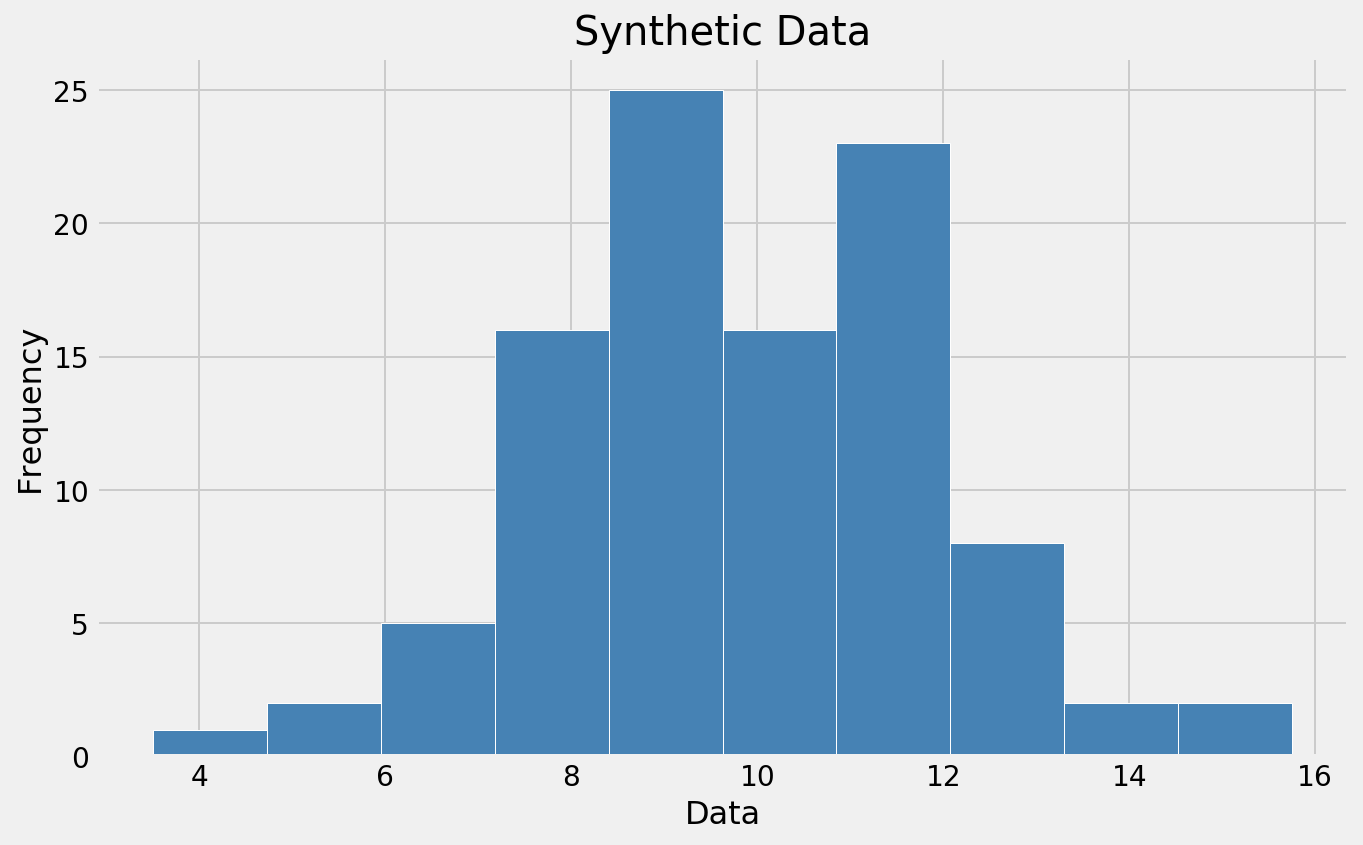

In [2]:
def generate_synthetic_data(mu, sigma, plot=False):
    data_meas = stats.norm.rvs(loc=mu, scale=sigma, size=100)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas

mu_param, sigma_param = 10, 2
normal_data_meas = generate_synthetic_data(mu_param, sigma_param, True)

***

<a id='a-log-likelihood_norm'></a>
***
<h2 align="center">Log-Likelihood Function</h2>

[Back to top](#part-a)

First, let's take a look at the new log-likelihood function. For distribution fitting, it is convenient to define the log-likelihood function. Say we have a parameter set that we want to calculate the log-likelihood score for: all we need to do is just calculate the product of the normal pdf for each data point respect to that set of parameter, then take the log of that product. Intutively, if these parameters are not close to the true parameters, then the product will become really small, if they are indeed close to the true parameters, we will get a decent score! This is what we want, because in Chapter 1, we mentioned that the likelihood function should describe the plausibility of parameters value based on data.

In [3]:
def normal_loglikelihood(parameters, data_meas):
    mu, sigma = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.norm.logpdf(x=data_meas[i], loc=mu, scale=sigma)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='a-log-prior_norm'></a>
***
<h2 align="center">Log-Prior Distribution</h2>

[Back to top](#part-a)

For the prior distribution, we will use a uniform distribution with upper bound $1000$ and lower bound $0$ for scale and a normal distribution with $\mu = 0$, $\sigma = 1000$ for the location parameter. Remember that the prior distribution is based on background information, here we assume we don't have much background information, so that is why we choose a uniform and a normal with a huge scale parameter value.

$$\pi(\sigma) = \begin{cases} \dfrac{1}{1000} & \text{if}~0 \leq \sigma \leq 1000 \\ 0 & \text{otherwise} \\ \end{cases}$$
</span>

$$\pi(\mu) = \frac{1}{1000\sqrt{2\pi}}e^{-\mu^2/2(1000^2)}$$


So the log-prior distribution for will be:

$$\log(\pi(\mu, \sigma)) = \log(\pi(\mu)) + \log(\pi(\sigma)) = \log\left(\dfrac{1}{1000}\right) + \log\left(\pi(\mu)\right) $$

In [4]:
def normal_logprior(parameters):
    mu, sigma = parameters
    
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    
    if sigma <= 0 or sigma >= 1000:
        return -np.inf
    
    return mu_logpdf + np.log(1 / 1000)

***

<a id='a-log-posterior_norm'></a>
***
<h2 align="center">Log-Posterior Distribution/Score</h2>

[Back to top](#part-a)

Just like the Chapter 1, we will add the the log-prior and log-likelihood together to get the log-posterior score. Remember that we are using the log-posterior score instead of the pdf of the posterior distribution (look at our explanation in Chapter 1).

In [5]:
def normal_logpost(parameters, data_meas):
    pi = normal_logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = normal_loglikelihood(parameters, data_meas)
    return LL + pi

***

<a id='a-run-algo_norm'></a>
***
<h2 align="center">Running the Algorithm</h2>

[Back to top](#part-a)

<br>

We can start our Metropolis-Hastings algorithm, We will run 3 sequences of 10,000 iterates each, and we will start the adaptation of the transition covariance matrix after 1,000 iterations. The runner is a helper function that allows generate markov chains easily!

In [6]:
def runner(
    m, n_iter, d, logpost, data_meas, t=1000, stepsize=[0.01, 0.01]
):
    # set up the different chains
    chains = []
    for i in range(m):
        mu_init = np.random.randint(low=6, high=12)
        sigma_init = np.random.randint(low=1, high=4)
        theta = [mu_init, sigma_init]
        chains.append(theta)
    # run the algorithm on all of the chains
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(chains[i], n_iter, stepsize, data_meas, logpost, t)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    # return
    return mcmc_chains, ar, ls

In [37]:
t=1000
normal_mcmc_chains, normal_ar, normal_ls = runner(m=3, n_iter=10000, t=t, data_meas=normal_data_meas, d=2, logpost=normal_logpost)

***

<a id='history-plots_norm'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#part-a)

<br>

Just like what we did in previous chapters, we want to plot the history plots for all parameters! As you can see the dashed black line is the true parameter value ... and according to the plots, we can clearly see that we are doing good on recovering the two true parameters!

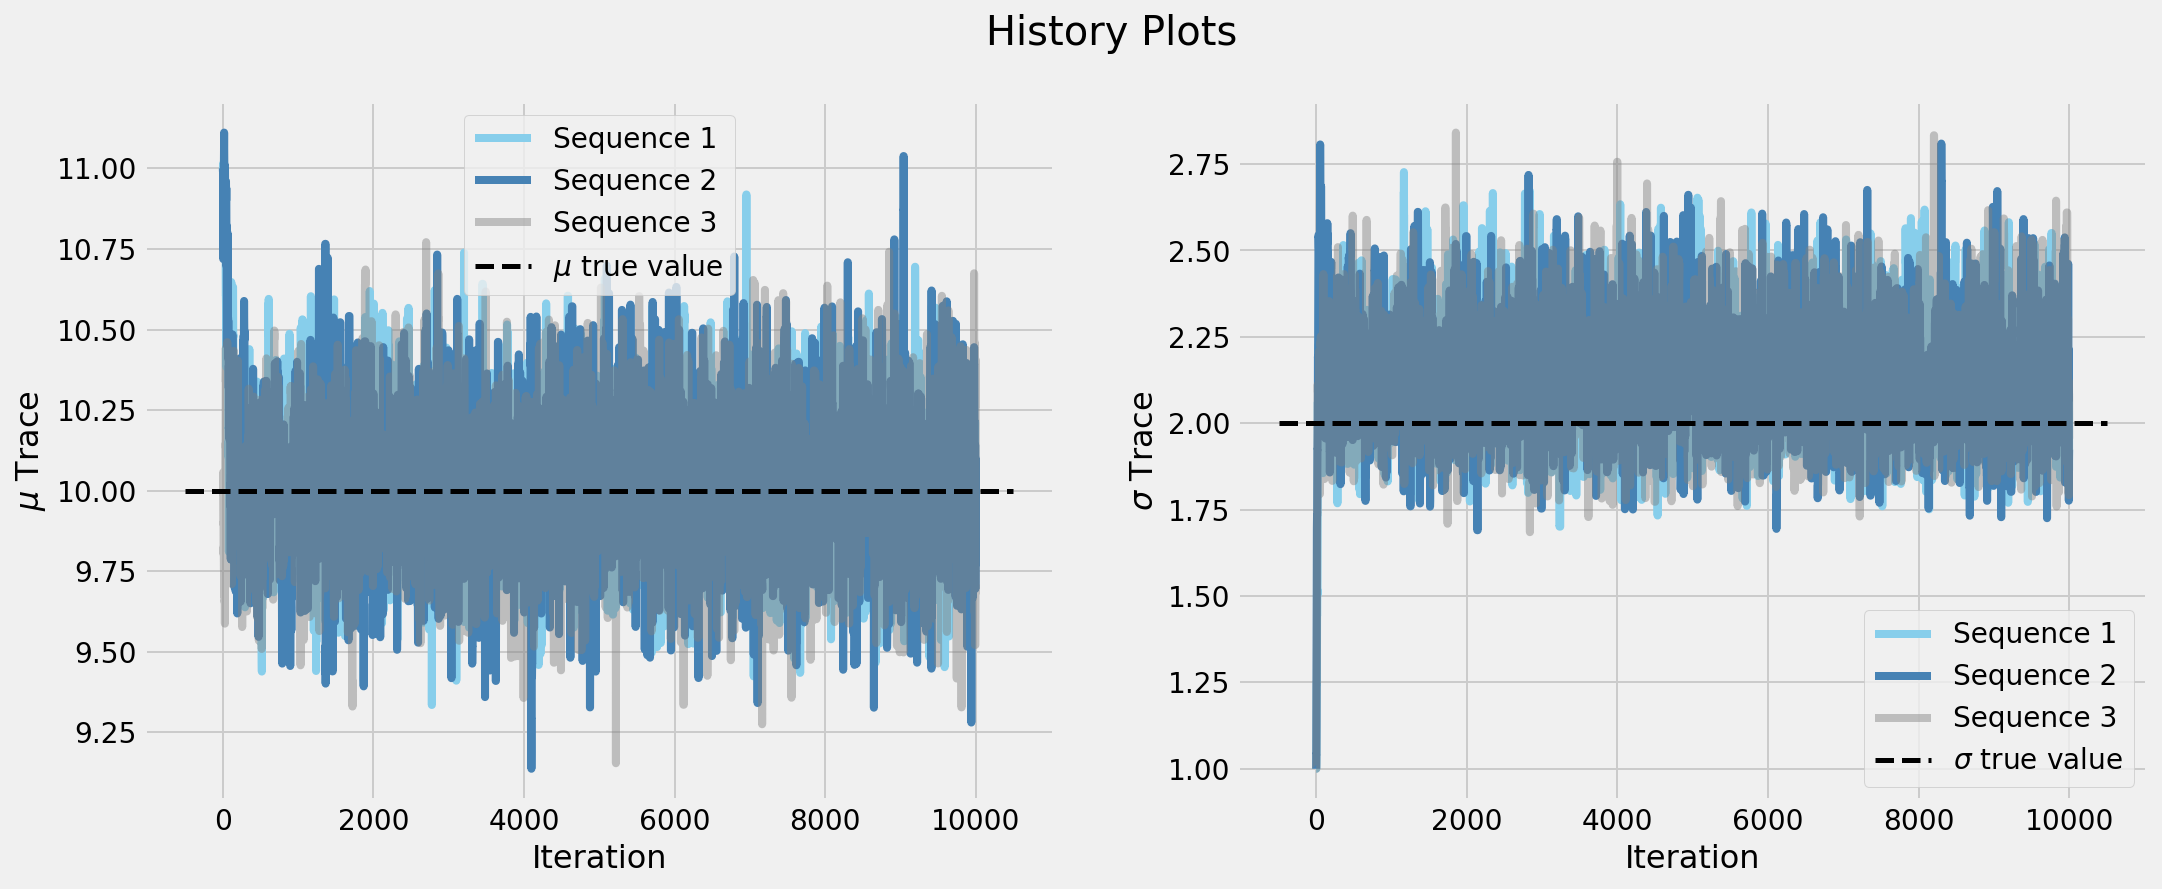

In [38]:
history_plots(normal_mcmc_chains, [r"$\mu$", r"$\sigma$"], [10, 2])

***

<a id='gr-diagnostic_norm'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>

[Back to top](#part-a)

In Chapter 1 we mentioned that it takes time to reach the posterior distribution, and we only want the part where the $3$ sequences are in the posterior distribution. Thus, we use the GR diagnostic to find that time (aka burn in period).

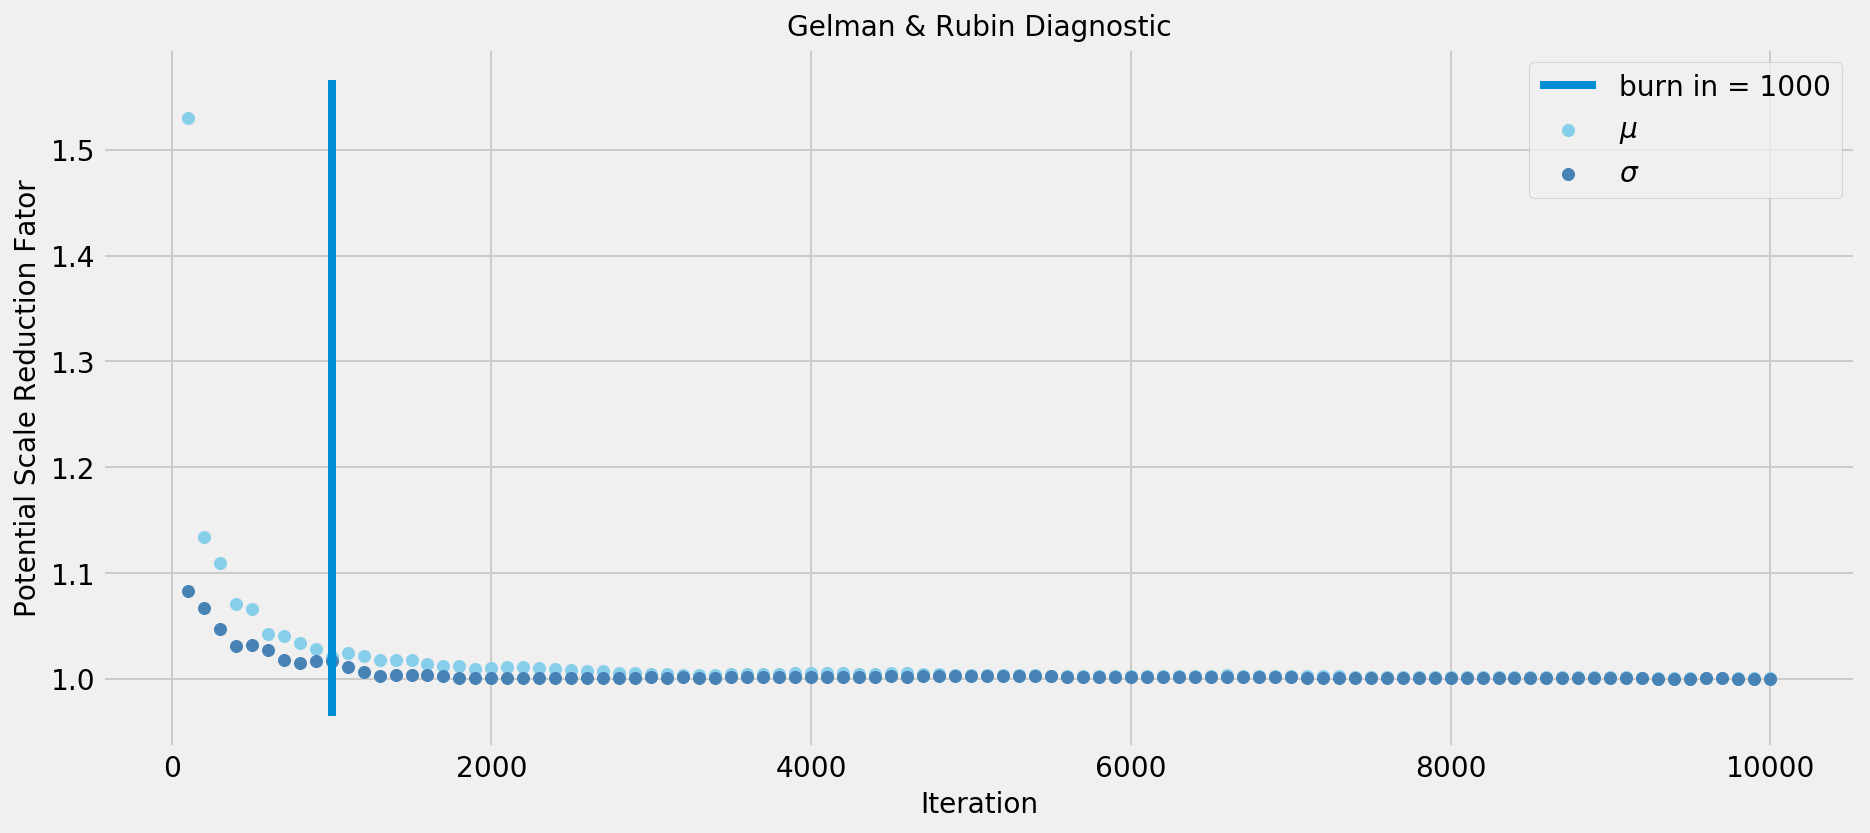

In [39]:
normal_burnin = GR_result(normal_mcmc_chains, [r"$\mu$", r"$\sigma$"], t)

***

<a id='ac-function_norm'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>

[Back to top](#part-a)

Again, we want the independent draws from the posterior distribution. To achieve this, we will use the auto-correlation function (aka thinning) to find the lag for each parameter in each sequenc. Then we'll find the largest lag among these two parameters and this will be the lag for the entire sequence.

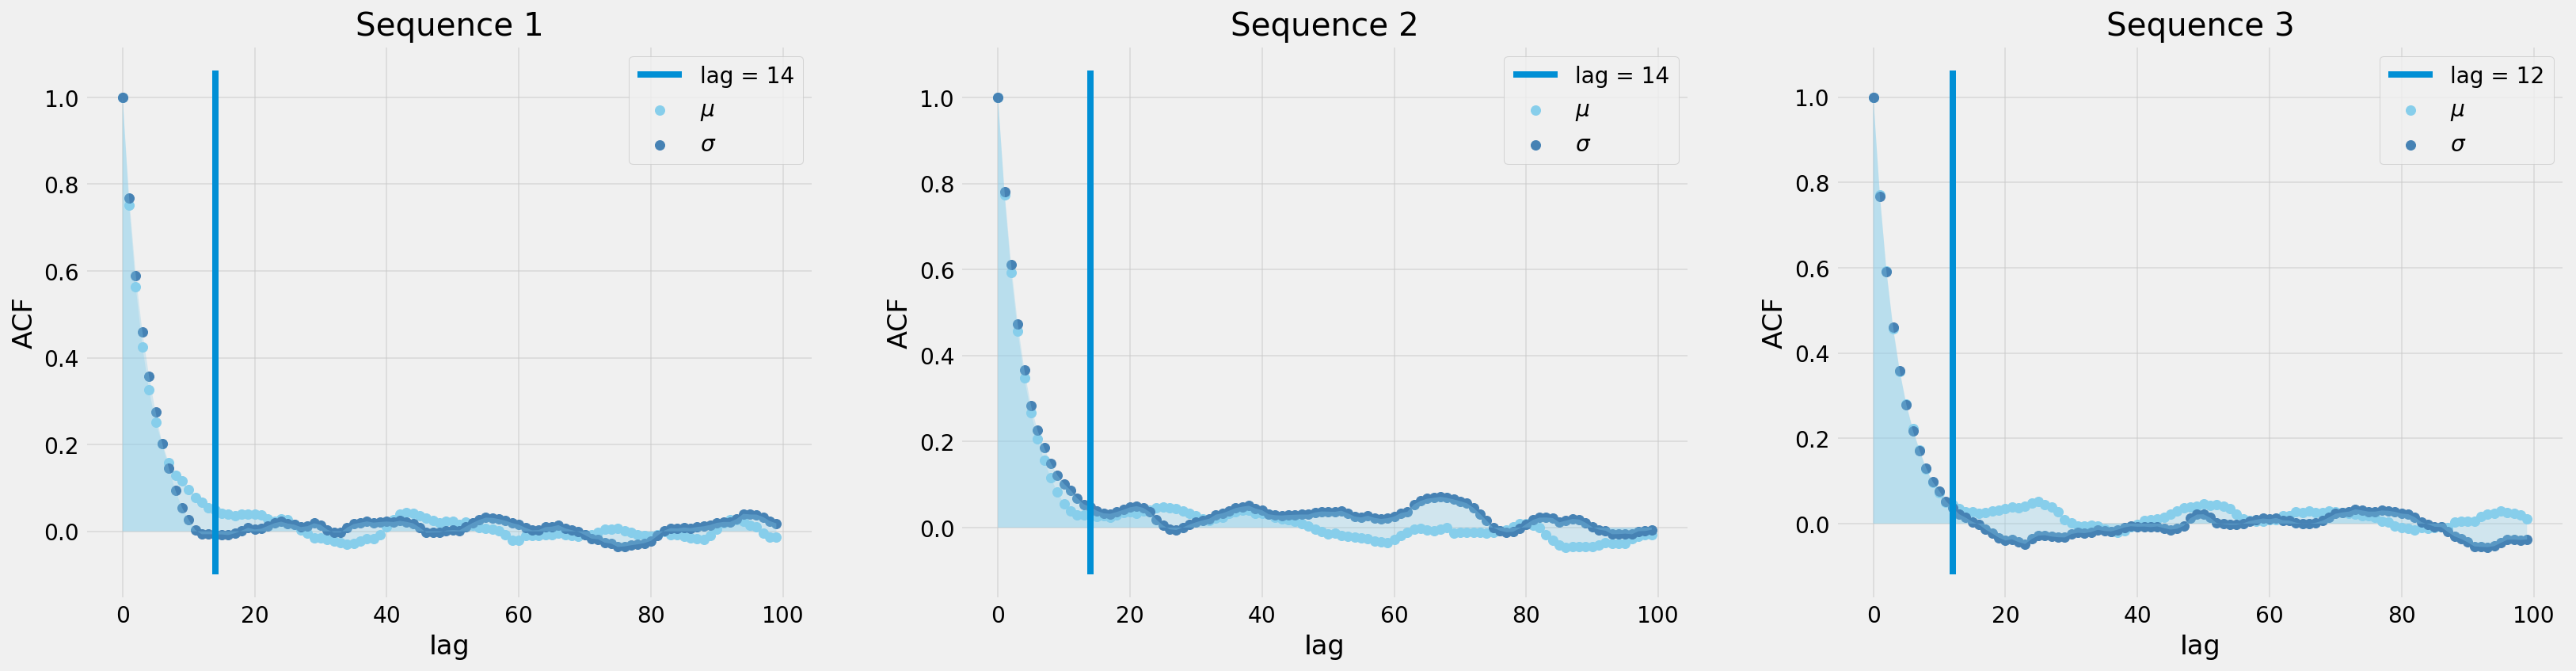

In [40]:
normal_lags = acf_result(normal_mcmc_chains, [r"$\mu$", r"$\sigma$"], normal_burnin)

***

<a id='histograms_norm'></a>
***
<h2 align="center">Density Plot For Each Parameter</h2>
[Back to top](#part-a)

<br>

Finally, after GR and thinning, we will have a pool of parameter sets, and we can plot the density plot for each parameter. Here, the vertical dashed black line represents the true parameter value, and you can see the results are pretty good!

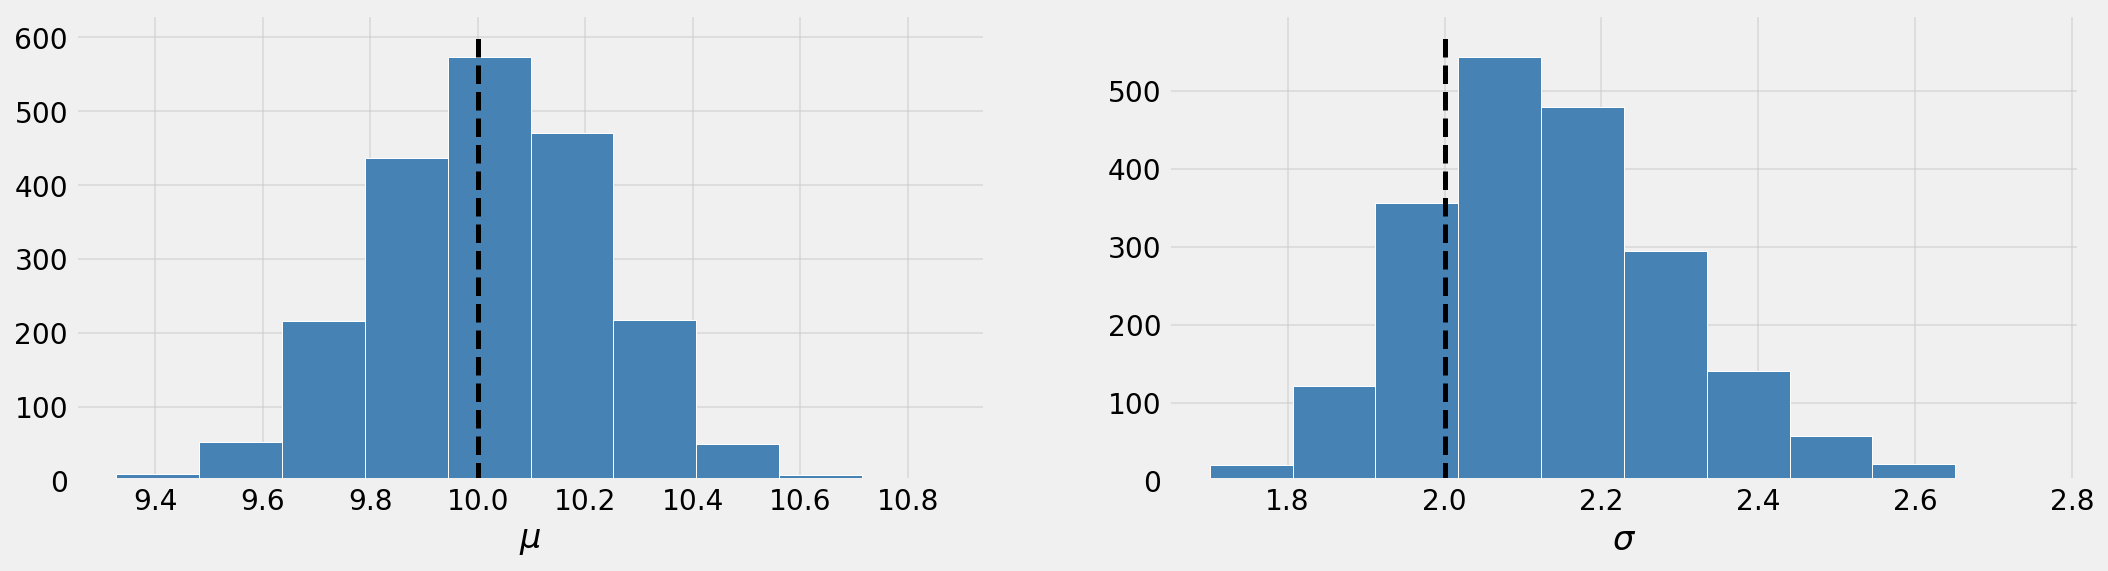

In [58]:
normal_params_analysis = final_params_pool(normal_mcmc_chains, normal_burnin, normal_lags, [r"$\mu$", r"$\sigma$"], True, [10, 2])

***

<a id='max-ls_norm'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>


[Back to top](#part-a)

In practice, we might be interested in knowing the maximum posterior score parameter set, because it represents the best parameters estimation we can get for this data set in our 3 markov chains. This special parameter set has a lot of information for different things! Also, the true parameter values are pretty close to the max log-posterior parameter values, which shows we can recover the parameters for normal distribution!

In [60]:
normal_max_params = max_ls_parameters(normal_ls, normal_mcmc_chains)
print ('The max log-posterior score parameter set is location = {:.3f}, scale = {:.3f},'.format(normal_max_params[0],normal_max_params[1]))

The max log-posterior score parameter set is location = 10.021, scale = 2.094,


***

***

<a id='part-b'></a>
***
<h1 align="center">Part B</h1>

Now, we show that we can fit a distribution with given data, let's move on! 

We care about extreme events in real life, some of these extreme events might be catastrophic, so we want to be able to predict these events, luckly there is such a distribution called generalized extreme value (GEV) distribution that can help us. The GEV distribution is applied to extreme events like storm surge. In order to do analysis with GEV distribution, we need to use MCMC to fit a GEV distribution, so let's get started!

### Table of Contents

- [Generate Synthetic Data](#b-synthetic-data_gev)
- [Log-Likelihood Function](#b-log-likelihood_gev)
- [Log-Prior Distribution](#b-log-prior_gev)
- [Log-Posterior Distribution](#b-log-posterior_gev)
- [Running the Algorithm](#b-run-algo_gev)
- [History Plots For Each Parameter](#history-plots_gev)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic_gev)
- [Auto Correlation Function Results](#ac-function_gev)
- [Histograms For Each Parameter](#histograms_gev)
- [Max Log-Posterior Score Parameter Set](#max-ls_gev)
- [Diagnostic Plots](#diagnostic-plots_gev)

[Back to top](#top)

<a id='b-synthetic-data_gev'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#part-b)

<br>

Before we work with the real data set, let's first show again we can recover all parameters for GEV distribution with synthetic data. There are three parameters in GEV distribution which are location($\mu$), scale($\sigma$), shape($\xi$), note that $\mu \in R$, $\xi \in R$ and $\sigma > 0$. So lets first generate some synthetic data from gev distribution that we are going to fit given parameters $\mu = 400$ and $\sigma = 100$ and $\xi = 0.4$, note that generate_synthetic_data_gev is just a helper function which can generate synthetic data.

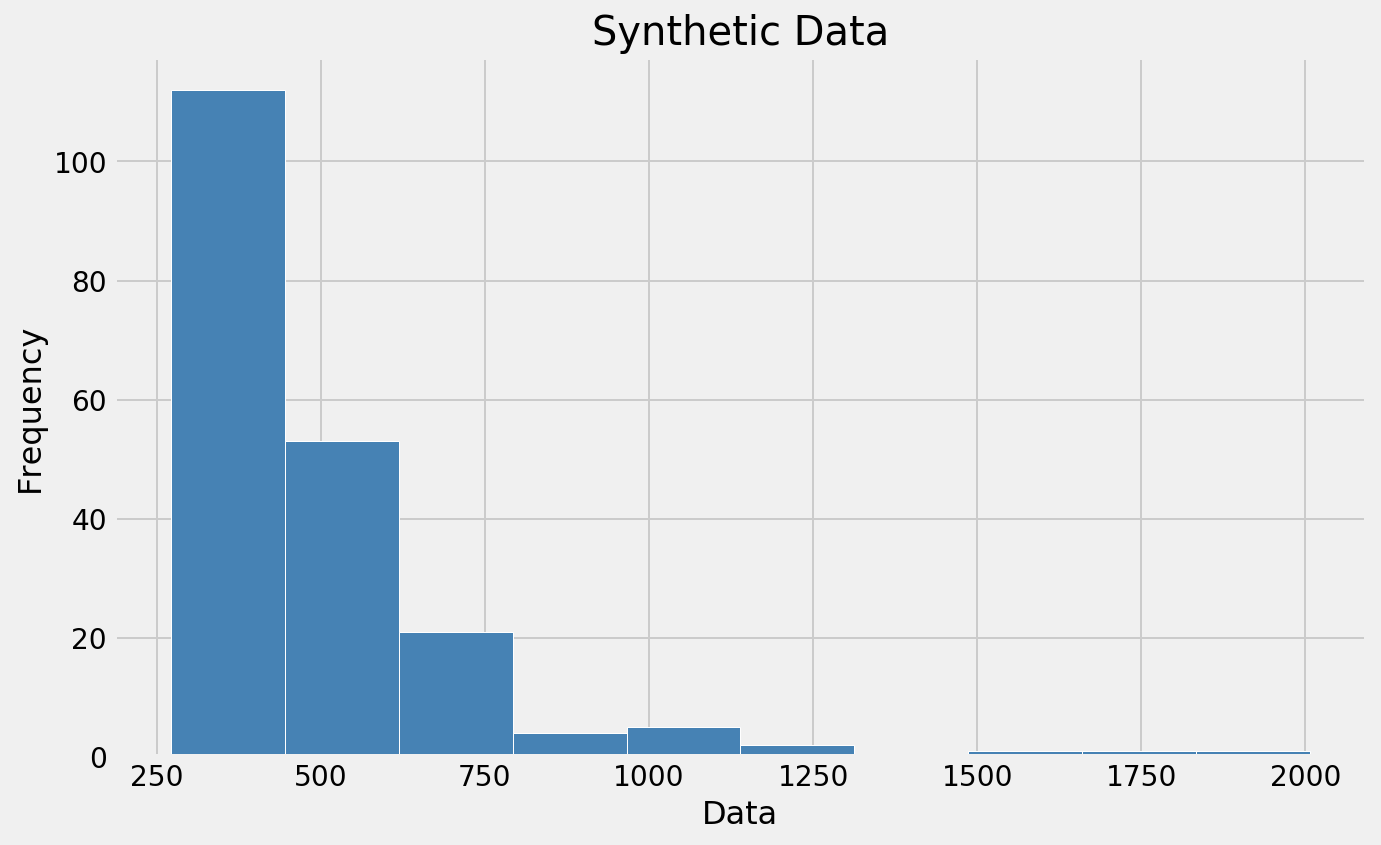

In [5]:
def generate_synthetic_data_gev(mu, sigma, shape, plot=False):
    data_meas = stats.genextreme.rvs(loc=mu, scale=sigma, c=-shape, size=200)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas

mu_param_gev, sigma_param_gev, shape_param_gev = 400, 100, 0.4
gev_data_meas = generate_synthetic_data_gev(mu_param_gev, sigma_param_gev, shape_param_gev, True)

***

<a id='b-log-likelihood_gev'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#part-b)

<br>

The likelihood function is almost exactly the same as the previous part, but now instead of using the Normal distribution's PDF, we are going to use the GEV distribution's PDF.

**Note that**, the support (domain) for GEV distribution depends on the shape parameter, there are three cases：
 
First, When shape is zero $(\xi = 0)$, the support for GEV will be $(-\infty, -\infty)$

Second, When shape is greater than zero $(\xi > 0)$, the support will be $(\mu-(\sigma / \xi), \infty)$

Finally, when shape is less than zero $(\xi < 0)$, the support will be $(-\infty, \mu-(\sigma / \xi))$

However, in Python this is in the opposite, meaning scipy has them flipped from typical convention, So we have to add '-' sign infront of the shape parameter everytime we use GEV in scipy!

In [6]:
def gev_loglikelihood(parameters, data_meas):
    mu, sigma, shape = parameters
    s = 0
    for i in range(len(data_meas)):
        # Add - sign for shape parameter
        logpdf = stats.genextreme.logpdf(x=data_meas[i], loc=mu, scale=sigma, c=-shape)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='b-log-prior_gev'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#part-b)

For prior distributions we will use normal distribution with $\mu = 0$ and $\sigma = 1000$ for both location and shape parameters, since their domain are both R, as for scale parameter, we will use uniform distribution with upper bound = $10000$ and lower bound = $0$, since scale has to be greater than zero.

$$\pi(\sigma) = \begin{cases} \dfrac{1}{10000} & \text{if}~0 \leq \sigma \leq 10000 \\ 0 & \text{otherwise} \\ \end{cases}$$
</span>

$$\pi(\mu) = \frac{1}{1000\sqrt{2\pi}}e^{-\mu^2/2(1000^2)}$$

$$\pi(\xi) = \frac{1}{1000\sqrt{2\pi}}e^{-\xi^2/2(1000^2)}$$


So the log-prior distribution for will be:

$$\log(\pi(\mu, \sigma, \xi)) = \log(\pi(\mu)) + \log(\pi(\sigma)) + \log(\pi(\xi)) = \log\left(\dfrac{1}{10000}\right) + \log\left(\pi(\mu)\right) + \log\left(\pi(\xi)\right)$$

<br>

In [7]:
def gev_logprior(parameters):
    mu, sigma, shape = parameters
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    shape_logpdf = stats.norm.logpdf(x=shape, loc=0, scale=1000)
    if sigma >= 10000 or sigma <= 0:
        return -np.inf
    else:
        return mu_logpdf + np.log(1 / 10000) + shape_logpdf

***

<a id='b-log-posterior_gev'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#part-b)

<br>

Same as the previous part, the log-posterior is still just the sum of the log-prior and the log-posterior:

In [8]:
def gev_logpost(parameters, data_meas):
    pi = gev_logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = gev_loglikelihood(parameters, data_meas)
    return LL + pi

***

<a id='b-run-algo_gev'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#part-b)

We can start our Metropolis-Hastings algorithm. We will run 3 sequences of 10,000 iterates each, and we will start the adaptation of the transition covariance matrix after 1,000 iterations. Here the sequences_generator is just another helper function.
<br>

In [9]:
def sequences_generator(m, n_iter, data_meas, logpost, t=1000, stepsize=[10, 2, 0.01]):
    np.seterr(divide='ignore', invalid='ignore')
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
    shape_est = 0
    
    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est+100)
        si = np.random.randint(low=scale_est, high=scale_est+100)
        shapei = shape_est
        theta =[ui, si, shapei]
        problems.append(theta)
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(problems[i], n_iter, stepsize, data_meas, logpost, t)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [10]:
t=1000
gev_mcmc_chains, gev_ar, gev_ls = sequences_generator(m=3, n_iter=10000, t=t, logpost=gev_logpost, data_meas=gev_data_meas)

***

<a id='history-plots_gev'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#part-b)

Again, we want to see the history plot for each parameter.


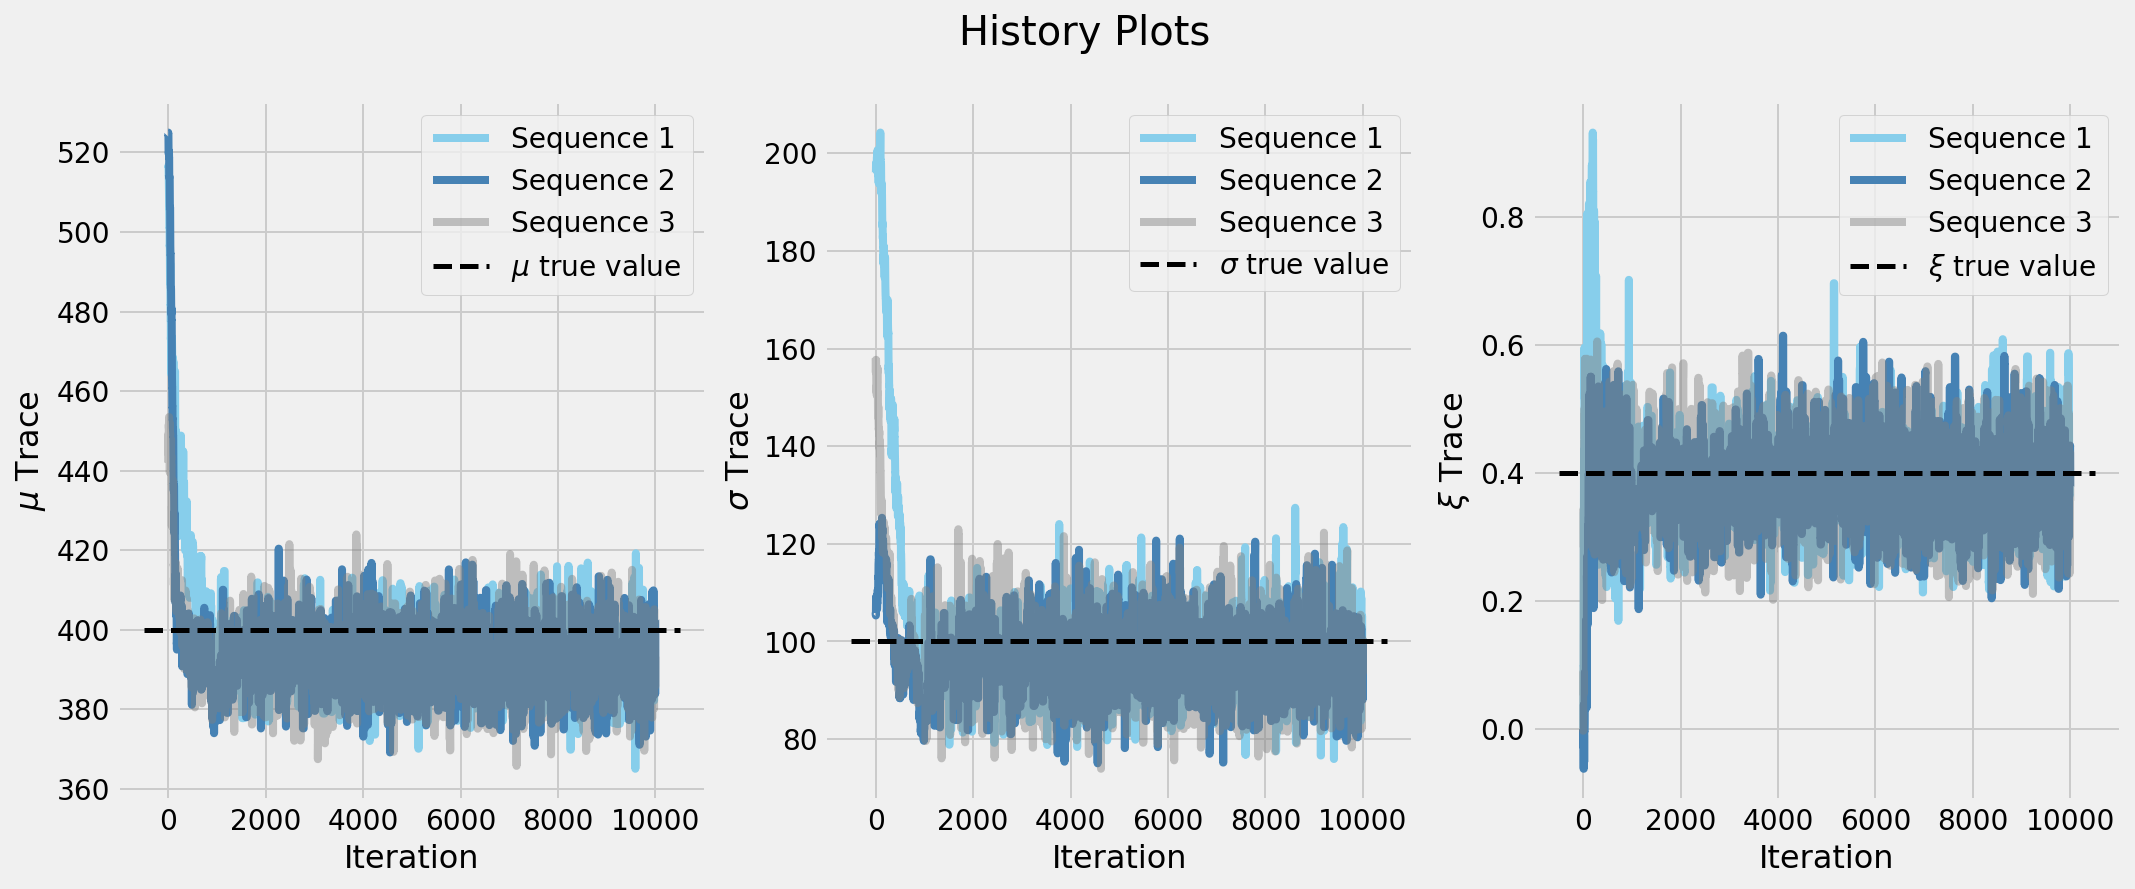

In [11]:
history_plots(gev_mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], [400, 100, 0.4])

***

<a id='gr-diagnostic_gev'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>
[Back to top](#part-b)

Here we can see the burn-in period is 

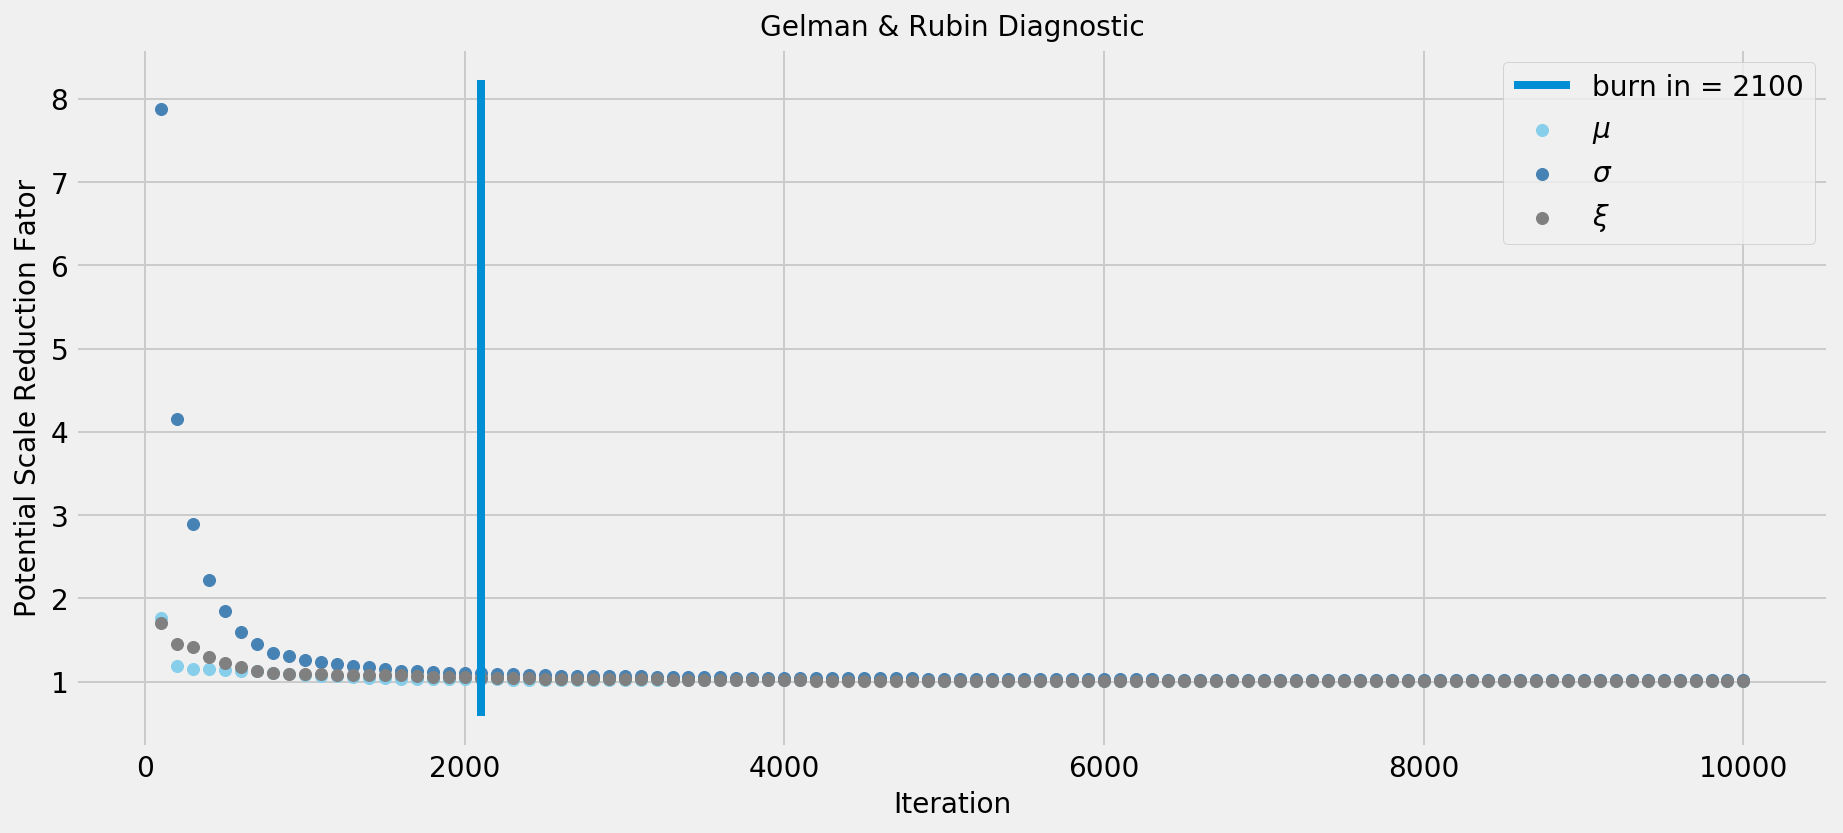

In [12]:
gev_burnin = GR_result(gev_mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], t)

****

<a id='ac-function_gev'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>
[Back to top](#part-b)

<br>

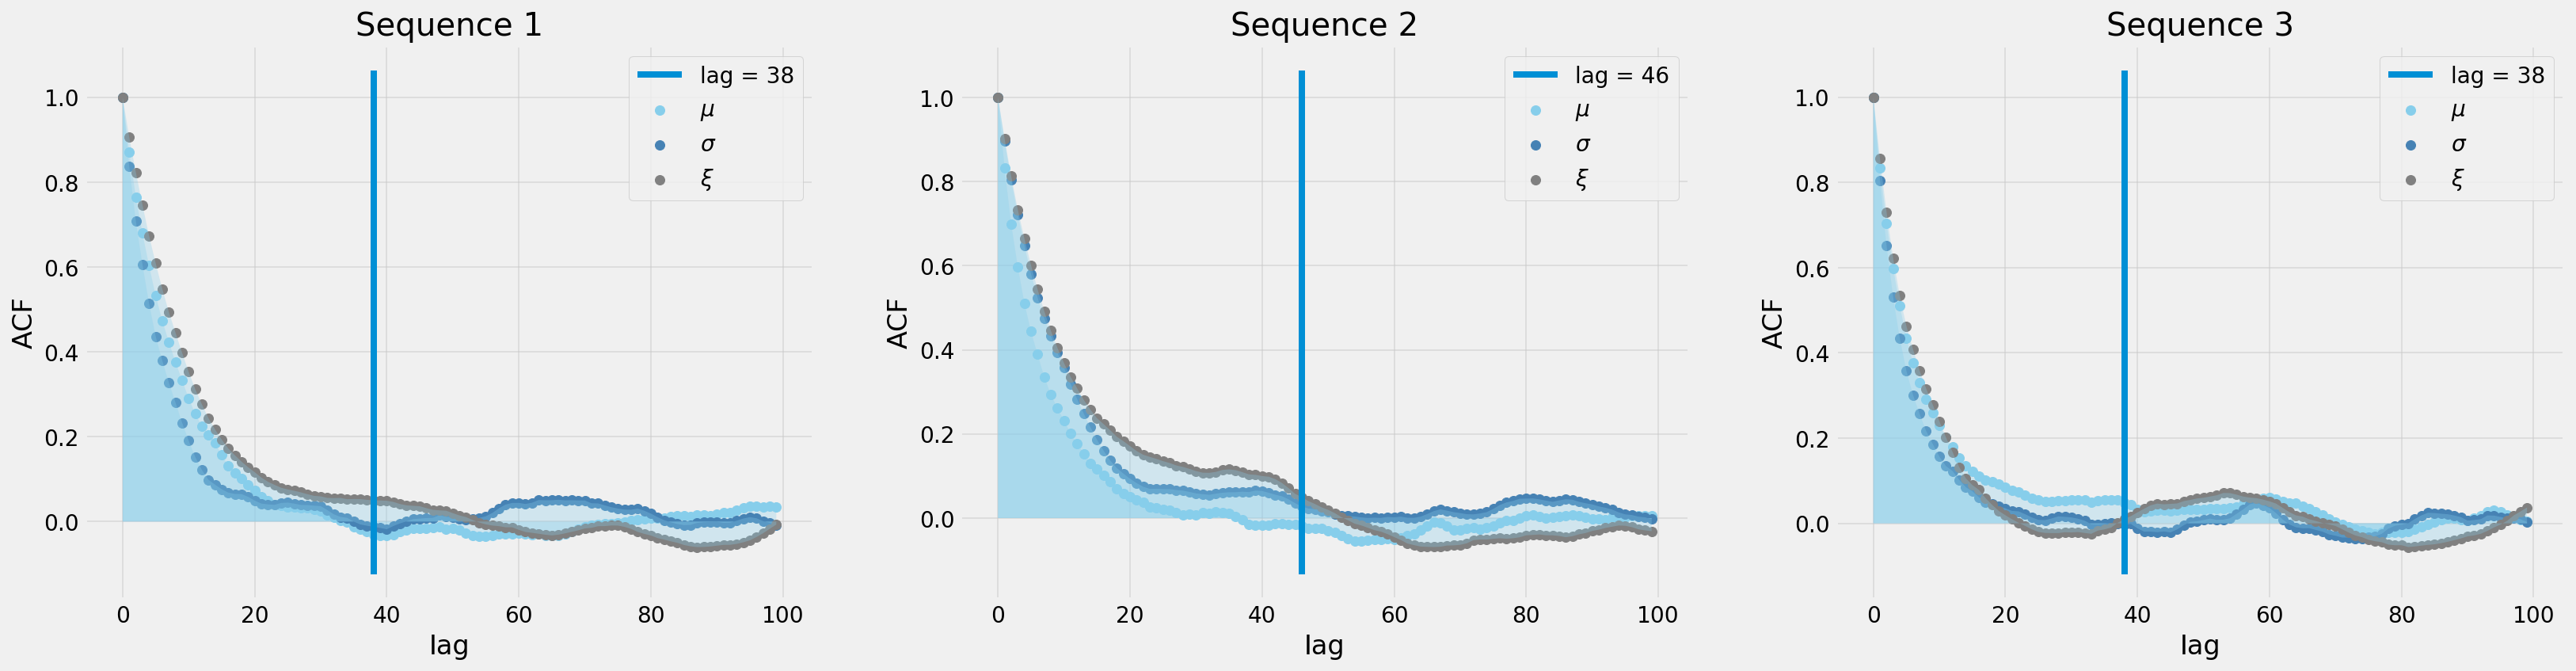

In [13]:
gev_lags = acf_result(gev_mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], gev_burnin)

***

<a id='histograms_gev'></a>
***
<h2 align="center">Histograms For Each Parameter</h2>
[Back to top](#part-b)

As you can see, with 200 synthetic data points, we got some very good estimations for all three parameters.
<br>

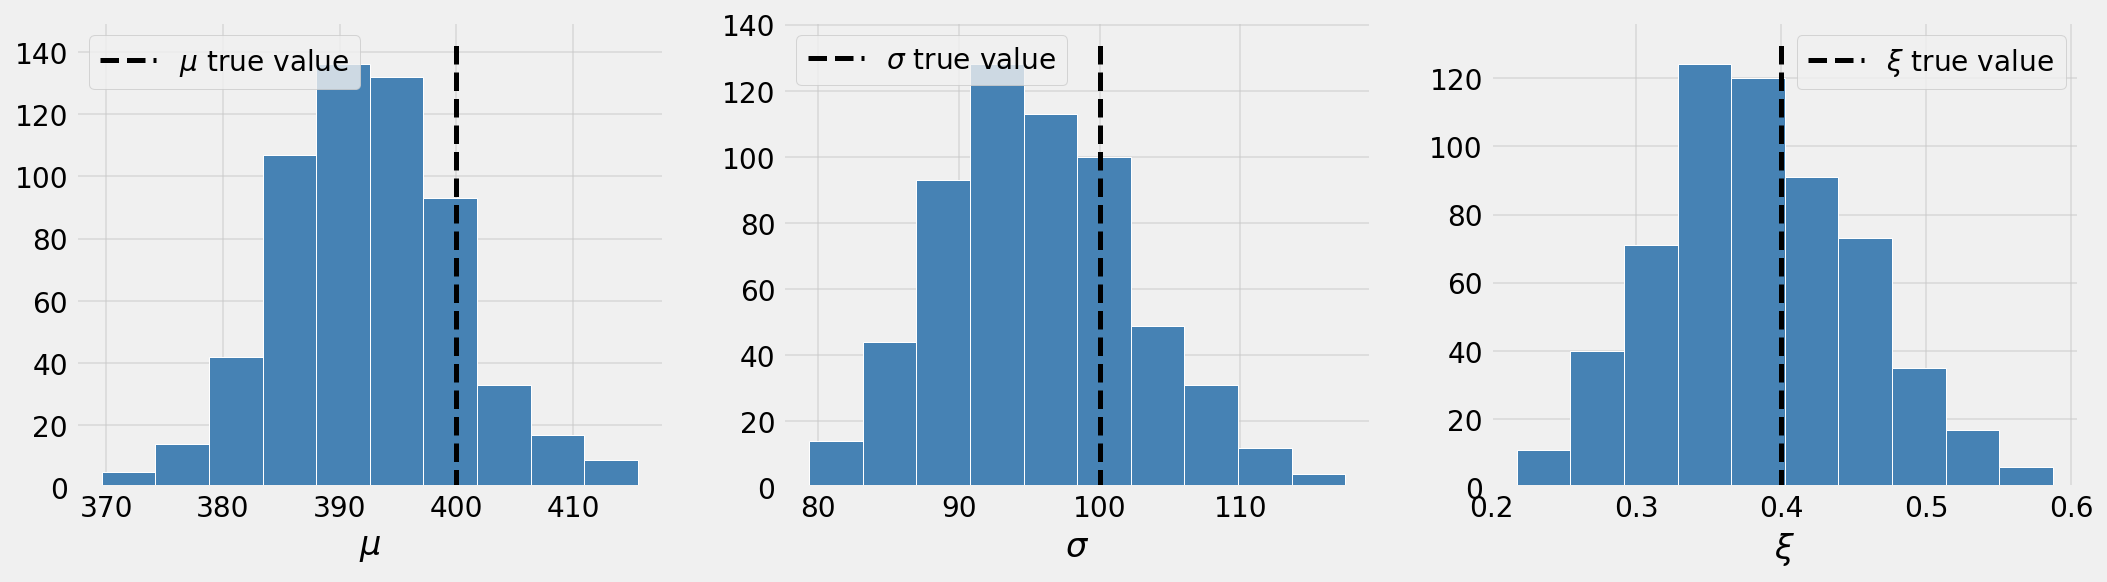

In [14]:
gev_params_analysis = final_params_pool(gev_mcmc_chains, gev_burnin, gev_lags, [r"$\mu$", r"$\sigma$", r"$\xi$"], True, [400, 100, 0.4])

***

<a id='max-ls_gev'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>
[Back to top](#part-b)

Again, the max log-posterior score parameter set are close to the true parameter values, which is what we want to show at the first place, now we will use the final parameter sets pool and the max ls parameter set to do some useful analysis!

In [15]:
gev_max_params = max_ls_parameters(gev_ls, gev_mcmc_chains)
print ('The max log-posterior score parameter set is location = {:.3f}, scale = {:.3f}, shape = {:.3f}'.format(gev_max_params[0],gev_max_params[1],gev_max_params[2]))

The max log-posterior score parameter set is location = 391.204, scale = 93.559, shape = 0.385


***

<a id='diagnostic-plots_gev'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#part-b)

Now we have a pool of parameter sets for GEV distribution and the max log-posterior score parameter set, we can actually do some useful analysis with them. We use GEV distribution to deal with some extreme events that we might want to predict, and in practice there are four diagnpstic plots we often use, they are probability plot, quantitle plot, return level plot and density plot. In this section we will introduce them one by one.

<br>

<br>

### 1. Probability Plot

The first plot is called probability plot, there are two components in this plot, the first component is a solid $y = x $ line, the second component are some scatter points whose x coordinate is the CDF value of each observation from synthetic data respect to the max log-posterior score parameter set and the y coordinate is the ECDF of the each corresponding observation, here the ECDF is the empirical cdf which can be calculated as following:

Suppose you have m observations (data points), we will sort all the observations by value from smallest to largest, then the ECDF value of the ith observation ($i \in 1, 2,3....m$) is $\dfrac{i}{m+1}$, m is the total number of observations.

What can we tell from this plot? If all the scatter points in your plot are very close to the $y=x$ line, then you have a decent model. Here as you can see, our model are pretty good!

Text(0,0.5,'Empirical')

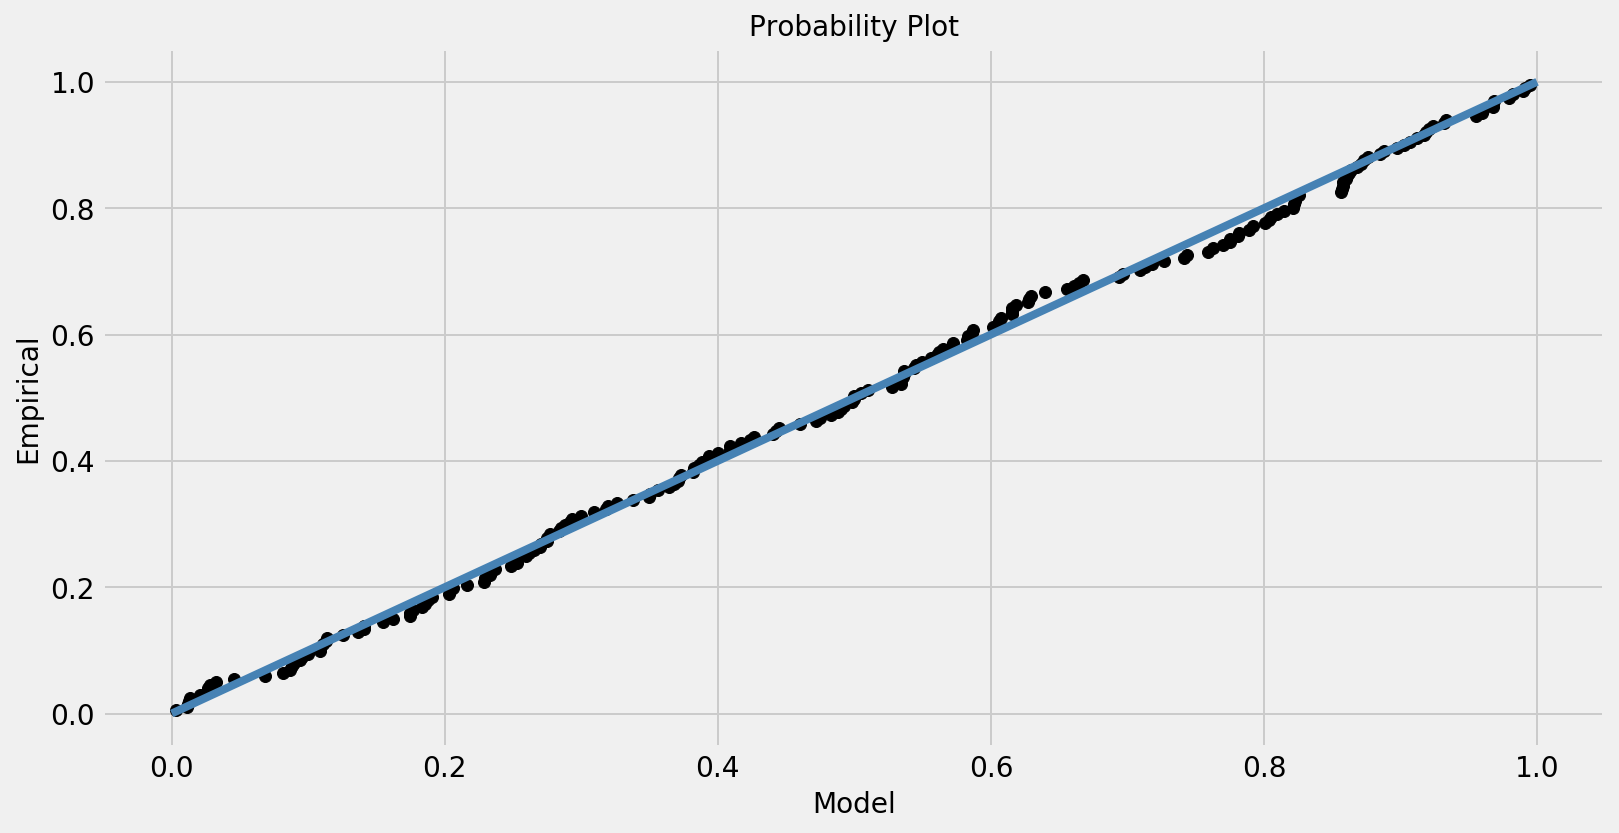

In [16]:
cdf = [stats.genextreme.cdf(x=np.sort(gev_data_meas)[i], c=-gev_max_params[2], loc=gev_max_params[0], scale=gev_max_params[1]) for i in range(len(gev_data_meas))]

plt.figure(figsize=(12, 6))
plt.scatter(cdf, [(i+1)/(len(gev_data_meas)+1) for i in range(len(gev_data_meas))], color='black')
plt.plot([0, 1], [0, 1], color='steelblue')
plt.title('Probability Plot', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical', fontsize=14)

<br>

### 2. Quantile Plot


The second plot is the quantitle plot, this plot will give us the similar information as the first one. This plot also has two components, the first component is still the $y=x$ line, the second component are some scatter points too, but the x coordinate is PPF of the ECDF of each observation respect to the max log-posterior parameter set, here the PPF is the inverse of CDF, and the y coordinate is the corresponding observation value.

Again, if the scatter points are close to the $y=x$ line, it indicates your model is good!

Text(0,0.5,'Empirical (in MM)')

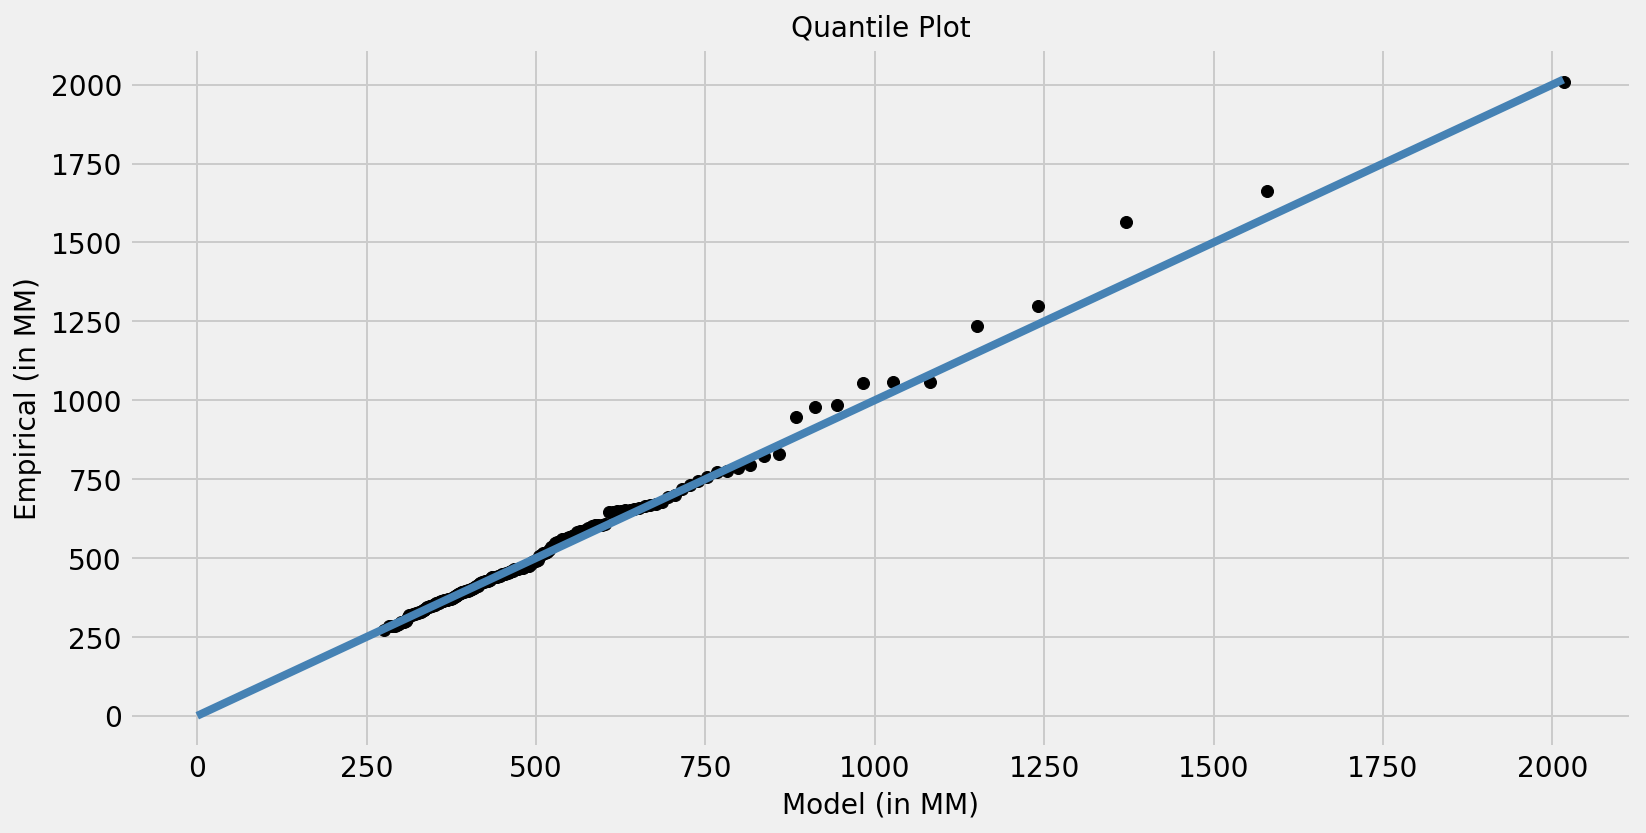

In [17]:
empirical = [stats.genextreme.ppf(q=(i+1)/(len(gev_data_meas)+1), c=-gev_max_params[2], loc=gev_max_params[0], scale=gev_max_params[1]) for i in range(len(gev_data_meas))]

plt.figure(figsize=(12, 6))
plt.scatter(empirical, np.sort(gev_data_meas), color='black')
plt.plot(np.arange(0, max(empirical)), np.arange(0, max(empirical)), color='steelblue')
plt.title('Quantile Plot', fontsize=14)
plt.xlabel('Model (in MM)', fontsize=14)
plt.ylabel('Empirical (in MM)', fontsize=14)

***

<br>

### 3. Return Level Plot


The return level plot might be the most important one among all diagnostic plots, because we mentioned above that we want to predict these extreme events in the future, in order to be prepared. The return plot will give us what we want.

The return level plot has several components, we will introduce them one by one:

The first component are the black scatter points, the y coordinate of the ith observation (after sorting) is the observation value and the x coordinate for the ith observation is $\dfrac{(m+1)}{(m+1-i)}$, where m is the total number of observations and $ i \in (1, 2, ...., m)$.

The second component is the red solid line whose x coordinate is the ith return period denoted as $RP[i]$, in our example the return period is from 1 to 500, and the corresponding y coordinate is the PPF of ($1 - \dfrac{1}{RP[i]}$) respect to the max log-posterior score parameter set, this value is also called by return level (respect to our best parameters estimation).

The third component is the slightly darker shaded area called 90% credible interval. In order to calculate this credible interval, we first calculate the return level corresponding to each return period for all parameter sets in our final parameter pool, then we calculate the 95 percentile for all the return levels corresponding to each return period, we also do the same thing respect to 5 percentile, then we plot these two lines and fill in the area between these two lines.

The last component is the lighter shaded area, and it's called 99% credible interval, the procedure will be the same as the 90% credible interval, but we will use 99.5 percentile and 0.5 percentile.

What can we get from this plot? If you see the red line overlaps very good with all the black scatter points that means we have a good model, if the two shaded area are really large that means the uncertainty are really big, on the countrary if the area are small, then the uncertainty are small too.

In [18]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=-gev_max_params[2], loc=gev_max_params[0], scale=gev_max_params[1]))
    for j in range(len(gev_params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=-gev_params_analysis[j][2], loc=gev_params_analysis[j][0], scale=gev_params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))

Text(0,0.5,'Return Level (in MM)')

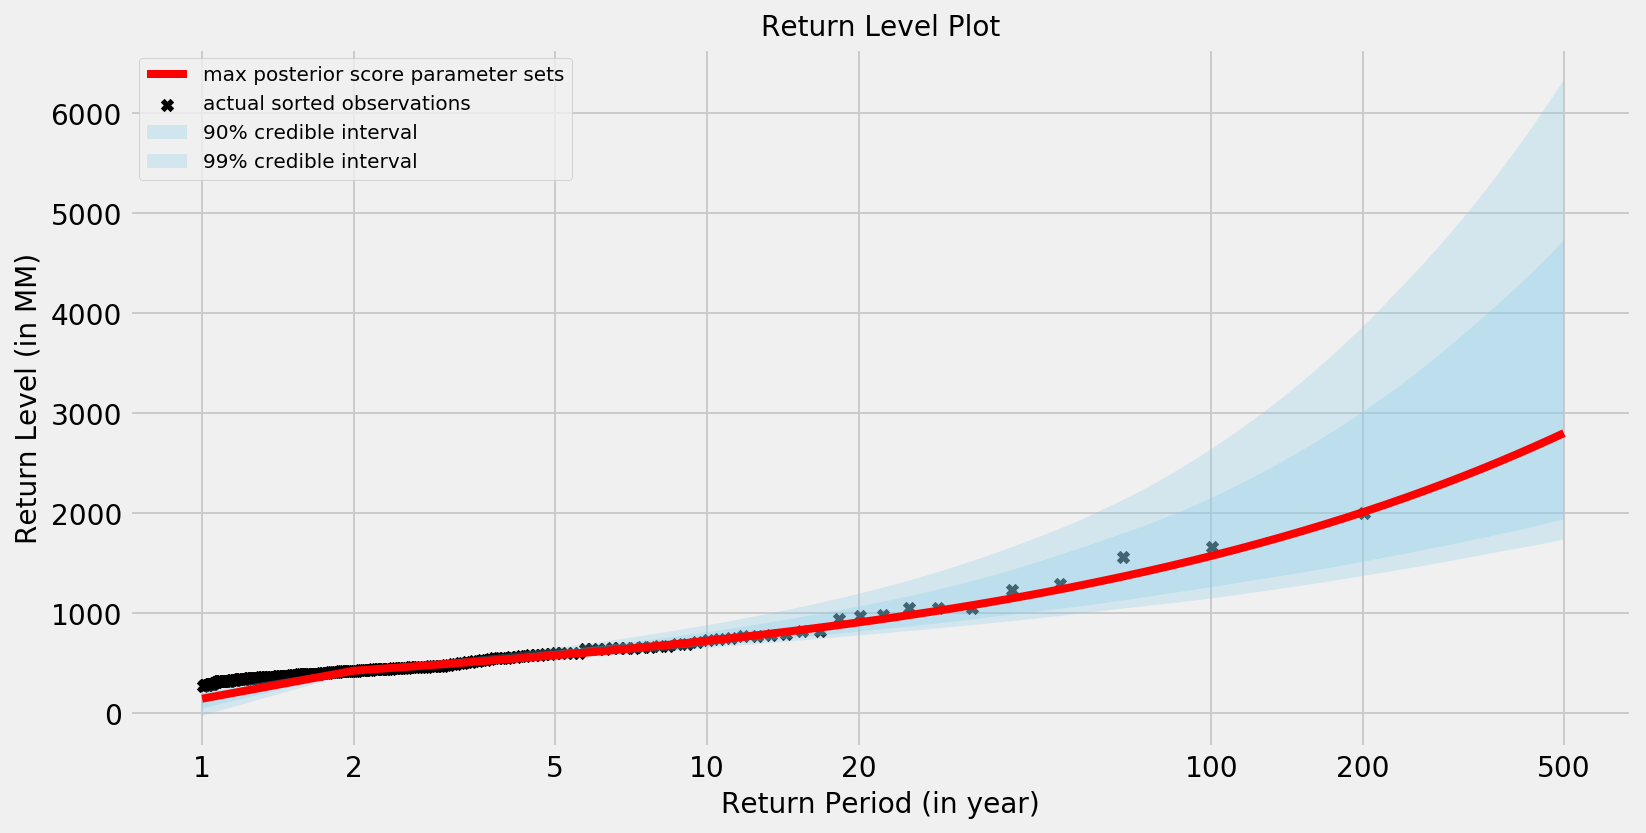

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
plt.scatter(np.log10([(len(gev_data_meas)+1)/(len(gev_data_meas)+1-k) for k in np.arange(1, len(gev_data_meas)+1, 1)]), np.sort(gev_data_meas), label='actual sorted observations', color='black', marker='X')
plt.fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
plt.fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
plt.legend(loc='upper left', fontsize=10)
plt.xticks(np.log10([1,2,5,10,20,100,200,500]), [1,2,5,10,20,100,200,500])
plt.title('Return Level Plot', fontsize=14)
plt.xlabel('Return Period (in year)', fontsize=14)
plt.ylabel('Return Level (in MM)', fontsize=14)

***

<br>

### 4. Density Plot

The last diagnostic plot is the density plot, this plot is also telling us how good is our estimation of parameters, the small vertical lines in the x-axis are the actual observations, we also have the histogram of the actual observations, the curve in the plot is the PDF values in some range respect to the max log-posterior score.

Text(0,0.5,'Density')

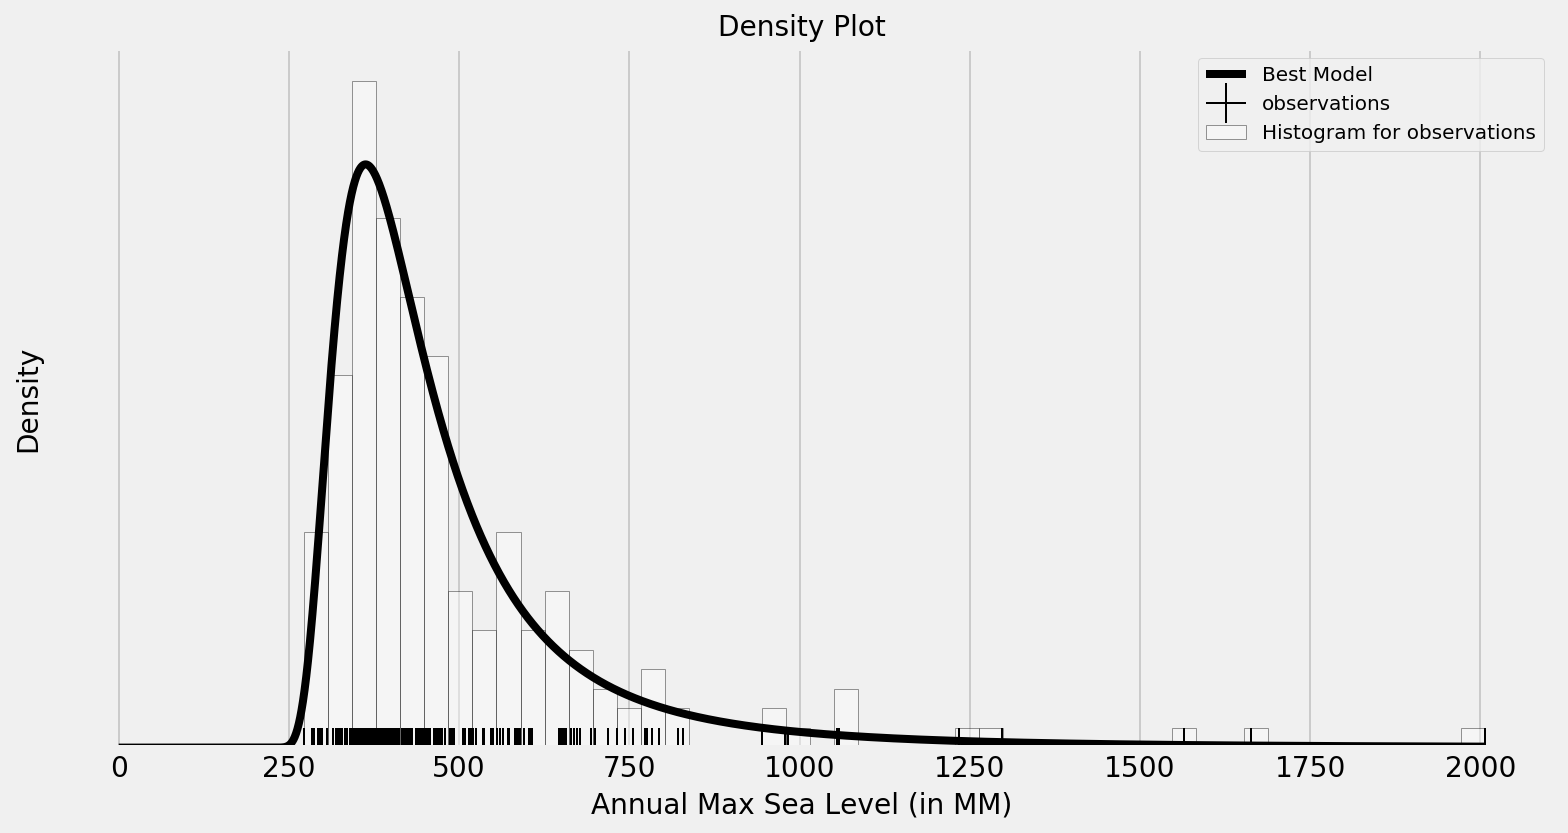

In [20]:
x_range = np.arange(0, max(gev_data_meas)+1, 0.5)
y_range = [stats.genextreme.pdf(x=xi, c=-gev_max_params[2], loc=gev_max_params[0], scale=gev_max_params[1]) for xi in x_range]

plt.figure(figsize=(12, 6))
plt.hist(gev_data_meas, bins=np.linspace(min(gev_data_meas), max(gev_data_meas)), density=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
plt.plot(x_range, y_range, label='Best Model', color='black')
plt.plot(gev_data_meas, np.zeros_like(gev_data_meas), 'b+', ms=20, color='black', label='observations')
plt.legend(loc='best', fontsize=10)
plt.yticks([])
plt.title('Density Plot', fontsize=14)
plt.xlabel('Annual Max Sea Level (in MM)', fontsize=14)
plt.ylabel('Density', fontsize=14)

***

In this chapter we show that we can fit a distribution with given data, and we also learned the four diagnostic plots for GEV distribution, in the next Chapter we will use all techniques we learned in Chapter 2B to work with real world data set, then solve some problems!

***

<a id='packages'></a>
***
<h2 align="center">Helper Functions and Packages</h2>

[Back to top](#top)

<br>

Below, is where we import all of the packages we use, and configure them. Note that we also set some global variables which we use when we plot!

In [2]:
# Imports
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
# Configurations
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format='retina'
# Global Variables
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]


def update_mean(m, X):
    N = len(X[0])
    n = []
    for i in range(len(m)):
        n.append([(m[i][0]*(N-1) + X[i][-1])/N])
    return np.array(n)

def update_cov(X, m, Ct, Sd, Id, eps):
    m1 = update_mean(m, X)
    t = len(X[0])-1
    part1 = ((t-1)/t)*Ct
    part2 = t*np.matmul(m, np.transpose(m))
    part3 = (t+1)*np.matmul(m1, np.transpose(m1))
    Xt = []
    Xt.append(X[:,-1])
    part4 = np.matmul(np.transpose(Xt), Xt)
    part5 = eps*Id
    cov = part1 + (Sd/t)*(part2 - part3 + part4 + part5)
    return (cov + np.transpose(cov))/2, m1

def random_move(current_state, X, Ct, t, t0, stepsize, data_meas, logpost, m, S_d, I_d):
    if (t <= t0):
        next_move = stats.multivariate_normal.rvs(current_state, stepsize)
        return next_move, logpost(next_move, data_meas), m, stepsize
    elif (t == t0 + 1):
        n = []
        for i in range(len(X)):
            n.append([np.mean(X[i])])
        cov = S_d*np.cov(X) + I_d*0.0001*S_d
        next_move = stats.multivariate_normal.rvs(current_state, cov)
        return next_move, logpost(next_move, data_meas), n, cov
    else:
        cov, m1 = update_cov(X, m, Ct, S_d, I_d, 0.0001)
        next_move = stats.multivariate_normal.rvs(current_state, cov)
        return next_move, logpost(next_move, data_meas), m1, cov
    
def adaptivemcmc(initial_state, n_iter, stepsize, data_meas, logpost, t0):
    d = len(initial_state)
    I_d = np.identity(d)
    S_d = (2.4)**2/d
    parameters = []
    current_state = initial_state
    current_value = logpost(initial_state, data_meas)
    for i in range(d):
        parameters.append([])
        parameters[i].append(initial_state[i])
    lpost = [current_value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    cov = stepsize
    m = []
    for t in range(n_iter):
        S += 1
        nextMove, nextValue, m, cov = random_move(current_state, np.array(parameters), cov, t, t0, stepsize, data_meas, logpost,m, S_d, I_d)
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            for i in range(d):
                parameters[i].append(nextMove[i])
            lpost.append(nextValue)
            current_state = nextMove
            current_value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                for i in range(d):
                    parameters[i].append(nextMove[i])
                lpost.append(nextValue)
                current_state = nextMove
                current_value = nextValue
            else:
                for i in range(d):
                    parameters[i].append(parameters[i][-1])
                lpost.append(lpost[-1])
    return (parameters, lpost, n_accept/S)

def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()
    
def GR_diag(parameter, interval=100, start=100):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

def GR_result(mcmc_chains, params, t, start=100, interval=100, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_raw, GR_params, burnin_params = [], [], []
    start, interval, end = start, interval, n
    for i in range(d):
        params_raw.append([])
        for j in range(m):
            params_raw[i].append(mcmc_chains[j][i])
    for i in range(d):
        GR, burnin = GR_diag(params_raw[i], interval, start)
        GR_params.append(GR)
        burnin_params.append(burnin)
    burnin = max(max(burnin_params), t)
    if plot:
        plt.figure(figsize=(14, 6))
        for i in range(d):
            plt.scatter(x=np.arange(start, end, interval), y=GR_params[i], label=params[i], color=COLORS[i % 3])
        plt.plot([burnin, burnin], plt.ylim(), label='burn in = {0}'.format(burnin))
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Potential Scale Reduction Fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    return burnin

def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ('Please increase the value of the end parameter for this function')
    return lag, acf

def acf_result(mcmc_chains, params, burnin, plot=True):
    lag_params, acf_params = [], []
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    end = 100
    for i in range(d):
        lag_params.append([])
        acf_params.append([])
        for j in range(m):
            lag, acf = ACF(mcmc_chains[j][i][burnin:], end)
            lag_params[i].append(lag)
            acf_params[i].append(acf)
    lags = [max(np.array(lag_params)[:,i]) for i in range(m)]
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=m, figsize=(25,6))
        for i in range(m):
            for j in range(d):
                ax[i].scatter(np.arange(0, end), acf_params[j][i], label=params[j], color=COLORS[j % 3])
                ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_params[j][i]), y1=acf_params[j][i], alpha=0.3, facecolor='skyblue')
            ax[i].plot([lags[i],lags[i]], ax[i].get_ylim(), label='lag = {0}'.format(lags[i]))
            ax[i].set_xlabel("Iag")
            ax[i].set_ylabel("ACF")
            ax[i].set_title("Sequence {0}".format(i+1))
            ax[i].legend(loc='best')
            ax[i].grid(alpha=0.5)
        plt.show()
    return lags

def final_params_pool(mcmc_chains, burnin, lags, params, plot=True, true_params=None):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_pool, params_ana = [], [[] for i in range(d)]
    for i in range(m):
        for j in range(burnin, n, lags[i]):
            params_pool.append([])
            for k in range(d):
                params_ana[k].append(mcmc_chains[i][k][j])
                params_pool[-1].append(mcmc_chains[i][k][j])
            
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=d, figsize=(16,4))
        for i in range(d):
            ax[i].hist(params_ana[i], color="steelblue", edgecolor='white')
            ax[i].set_xlabel(params[i])
            if true_params is not None:
                ax[i].plot(
                    [true_params[i], true_params[i]],
                    ax[i].get_ybound(),
                    color="black",
                    linestyle="dashed",
                    label= params[i] + " true value",
                    linewidth=2.5,
                )
            ax[i].legend(loc='best')
            ax[i].grid(alpha=0.5)
        plt.show()  
    return params_pool

def max_ls_parameters(ls, mcmc_chains):
    max_indices = []
    maxs = []
    for i in range(len(mcmc_chains)):
        max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
        maxs.append(np.array(ls[i]).max())
    seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
    iterj = max_indices[seqi]
    max_params = []
    d = len(mcmc_chains[0])
    for i in range(d):
        max_params.append(mcmc_chains[seqi][i][iterj])
    return max_params

[Back to top](#top)